In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights

from Model_calibration_dataset import get_cifar10_classes
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

In [2]:
# Retrieve datasets and dataloaders
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])
train_dataset, val_dataset, test_data = get_cifar10_classes(transform_train, transform_test)

# Create dataloader
batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Common functions
class LabelSmoothingBCE(nn.Module):  # CrossEntropyLoss has label smoothing, BCE does not
    def __init__(self, smoothing=0.0):
        super(LabelSmoothingBCE, self).__init__()
        assert 0.0 <= smoothing < 1.0
        self.smoothing = smoothing
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, logits, target):
        with torch.no_grad():
            target = target * (1 - self.smoothing) + (self.smoothing / 2)
        return self.loss_fn(logits, target)
    

def train_model(lr, train_loader, smoothing, finetune=False, num_epoch=10):
    if finetune:
        model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    else:
        model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 1)  # binary classification
    model.to(device)
    criterion = LabelSmoothingBCE(smoothing)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epoch}, Loss: {epoch_loss:.4f}')
    return model


def evaluate(model, dataloader, label=''):
    model.eval()
    val_logits = []
    val_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images).cpu().numpy().flatten()
            val_logits.extend(outputs)
            val_labels.extend(labels.numpy())
    val_logits = np.array(val_logits).reshape(-1, 1)
    val_labels = np.array(val_labels)
    return val_logits, val_labels
    


def evaluate_calibration(model, data_loader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_probs.extend(outputs)
            all_labels.extend(labels.numpy())
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    # Plot reliability curve
    prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)
    return prob_true, prob_pred


def evaluate_calibration_scaling(model, platt_model, test_loader):
    model.eval()
    test_logits = []
    test_labels = []
    with torch.no_grad():
        for image, labels in test_loader:
            image = image.to(device)
            outputs = model(image)
            test_logits.extend(outputs.detach().cpu().numpy().flatten())
            test_labels.extend(labels.numpy())
        test_logits = np.array(test_logits).reshape(-1, 1)
        calibrated_probs = platt_model.predict_proba(test_logits)[:, 1]  # similar to 1 / (1 + np.exp(-A * test_logits - B))
    return test_labels, calibrated_probs

In [ ]:
# Finetune with label smoothing and evaluate calibration 
smoothing_values = [0.0, 0.1, 0.2, 0.3]
results = {}
for alpha in smoothing_values:
    print(f'Finetuning with alpha value: {alpha}')
    plt.figure(figsize=(8, 6))
    model = train_model(0.001, train_loader, alpha, finetune=True)
    label = f'Alpha: {alpha}'
    prob_true, prob_pred = evaluate_calibration(model, test_loader, label)
    results[int(alpha * 10)] = {
        'prob_true': prob_true,
        'prob_pred': prob_pred,
    }
# Plot
plt.figure(figsize=(8, 6))
for alpha in smoothing_values:
    prob_true = results[alpha*10]['prob_true']
    prob_pred = results[alpha*10]['prob_pred']
    plt.plot(prob_pred, prob_true, marker='o', label=f'Label Smoothing: {alpha}')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')  # Draw diagonal
plt.title('Reliability with label smoothing -- Pretrained')
plt.xlabel('Predicted probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

In [ ]:
# Train from scratch with label smoothing
smoothing_values = [0.0, 0.1, 0.2, 0.3]
results = {}
for alpha in smoothing_values:
    print(f'Finetuning with alpha value: {alpha}')
    plt.figure(figsize=(8, 6))
    model = train_model(0.001, train_loader, alpha)
    label = f'Alpha: {alpha}'
    prob_true, prob_pred = evaluate_calibration(model, test_loader, label)
    results[int(alpha * 10)] = {
        'prob_true': prob_true,
        'prob_pred': prob_pred,
    }
# Plot
plt.figure(figsize=(8, 6))
for alpha in smoothing_values:
    prob_true = results[alpha*10]['prob_true']
    prob_pred = results[alpha*10]['prob_pred']
    plt.plot(prob_pred, prob_true, marker='o', label=f'Label Smoothing: {alpha}')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')  # Draw diagonal
plt.title('Reliability with label smoothing -- Trained from scratch')
plt.xlabel('Predicted probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

In [8]:
# Apply platt scaling on models from previous two parts (pretrained & scratch) and the one from part 1 (temperature 0.0)
def platt_scaling(finetune=False, label=''):
    smoothing_values = [0.0, 0.1, 0.2, 0.3]
    results = {}
    for alpha in smoothing_values:
        if finetune:
            print(f'Finetuning with alpha value: {alpha}')
        else:
            print(f'Training from scratch with alpha value: {alpha}')
        plt.figure(figsize=(8, 6))
        model = train_model(0.001, train_loader, alpha, finetune=finetune)
        # Apply platt scaling
        val_logits, val_labels = evaluate(model, val_loader)
        platt_model = LogisticRegression(solver='lbfgs')
        platt_model.fit(val_logits, val_labels)
        test_labels, test_logits = evaluate_calibration_scaling(model, platt_model, test_loader)
        prob_true_cal, prob_pred_cal = calibration_curve(test_labels, test_logits, n_bins=10)
        results[int(alpha * 10)]={
            'prob_true': prob_true_cal,
            'prob_pred': prob_pred_cal,
        }
    
    # Plot after scaling
    plt.figure(figsize=(8, 6))
    for alpha in smoothing_values:
        prob_true = results[int(alpha * 10)]['prob_true']
        prob_pred = results[int(alpha * 10)]['prob_pred']
        plt.plot(prob_pred, prob_true, marker='o', label=f'Label Smoothing: {alpha}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')  # Draw diagonal
    plt.title(f'Reliability with label smoothing -- {label}')
    plt.xlabel('Predicted probability')
    plt.ylabel('Fraction of Positives')
    plt.legend()
    plt.show()

Training from scratch with alpha value: 0.0
Epoch 1/10, Loss: 0.7219
Epoch 2/10, Loss: 0.6542
Epoch 3/10, Loss: 0.6206
Epoch 4/10, Loss: 0.6014
Epoch 5/10, Loss: 0.5825
Epoch 6/10, Loss: 0.5668
Epoch 7/10, Loss: 0.5479
Epoch 8/10, Loss: 0.5349
Epoch 9/10, Loss: 0.5199
Epoch 10/10, Loss: 0.5070
Training from scratch with alpha value: 0.1
Epoch 1/10, Loss: 0.7170
Epoch 2/10, Loss: 0.6672
Epoch 3/10, Loss: 0.6439
Epoch 4/10, Loss: 0.6276
Epoch 5/10, Loss: 0.6133
Epoch 6/10, Loss: 0.6031
Epoch 7/10, Loss: 0.5913
Epoch 8/10, Loss: 0.5833
Epoch 9/10, Loss: 0.5695
Epoch 10/10, Loss: 0.5623
Training from scratch with alpha value: 0.2
Epoch 1/10, Loss: 0.7098
Epoch 2/10, Loss: 0.6768
Epoch 3/10, Loss: 0.6596
Epoch 4/10, Loss: 0.6468
Epoch 5/10, Loss: 0.6350
Epoch 6/10, Loss: 0.6257
Epoch 7/10, Loss: 0.6184
Epoch 8/10, Loss: 0.6141
Epoch 9/10, Loss: 0.6038
Epoch 10/10, Loss: 0.5965
Training from scratch with alpha value: 0.3
Epoch 1/10, Loss: 0.7347
Epoch 2/10, Loss: 0.6928
Epoch 3/10, Loss: 0.6

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

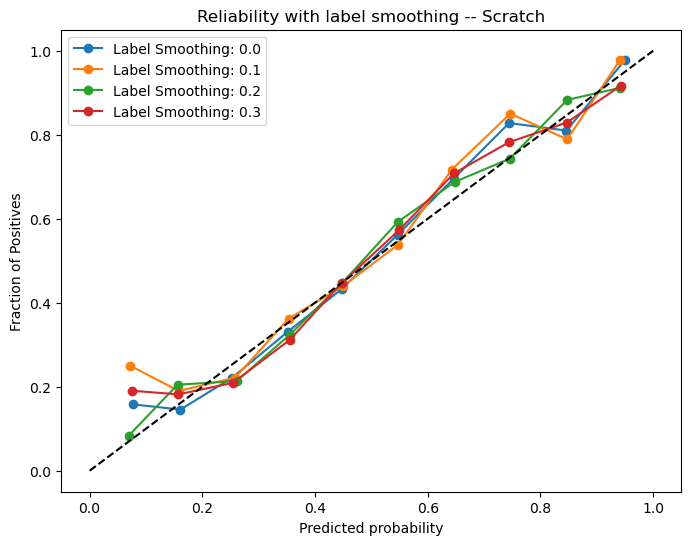

Finetuning with alpha value: 0.0
Epoch 1/10, Loss: 0.7160
Epoch 2/10, Loss: 0.6514
Epoch 3/10, Loss: 0.6224
Epoch 4/10, Loss: 0.5991
Epoch 5/10, Loss: 0.5772
Epoch 6/10, Loss: 0.5653
Epoch 7/10, Loss: 0.5448
Epoch 8/10, Loss: 0.5321
Epoch 9/10, Loss: 0.5205
Epoch 10/10, Loss: 0.5061
Finetuning with alpha value: 0.1
Epoch 1/10, Loss: 0.7135
Epoch 2/10, Loss: 0.6663
Epoch 3/10, Loss: 0.6452
Epoch 4/10, Loss: 0.6249
Epoch 5/10, Loss: 0.6113
Epoch 6/10, Loss: 0.5965
Epoch 7/10, Loss: 0.5851
Epoch 8/10, Loss: 0.5752
Epoch 9/10, Loss: 0.5674
Epoch 10/10, Loss: 0.5559
Finetuning with alpha value: 0.2
Epoch 1/10, Loss: 0.7191
Epoch 2/10, Loss: 0.6789
Epoch 3/10, Loss: 0.6588
Epoch 4/10, Loss: 0.6460
Epoch 5/10, Loss: 0.6358
Epoch 6/10, Loss: 0.6234
Epoch 7/10, Loss: 0.6172
Epoch 8/10, Loss: 0.6083
Epoch 9/10, Loss: 0.6040
Epoch 10/10, Loss: 0.5971
Finetuning with alpha value: 0.3
Epoch 1/10, Loss: 0.7303
Epoch 2/10, Loss: 0.6924
Epoch 3/10, Loss: 0.6740
Epoch 4/10, Loss: 0.6641
Epoch 5/10, Los

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

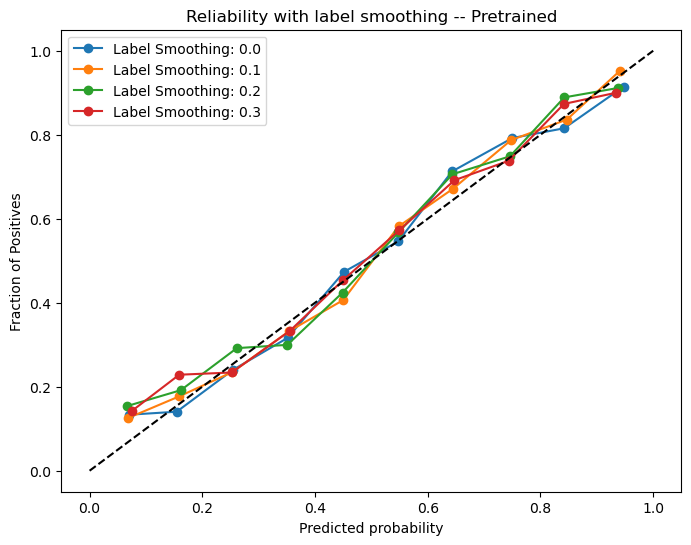

In [9]:
# Execute
platt_scaling(False, 'Scratch')
platt_scaling(True, 'Pretrained')